In [1]:
# @matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
# from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for exmaple, change tghe context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind",color_codes=True,
              rc={"figure.figsize":[12, 8]})

# Exploring `faitai`s Tabular Learner

## How to do it

### 1. Import the libraries

In [3]:
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from evaluation_report import performance_evaluation_report
from evaluation_report import performance_evaluation_report_fastai
import pandas as pd

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load the dataset from a CSV file

In [4]:
df = pd.read_csv('./datasets/credit_card_default.csv')

df.head()

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Paid duly,Paid duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Paid duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Paid duly,Unknown,Paid duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.isna().any()

limit_bal                     False
sex                            True
education                      True
marriage                       True
age                            True
payment_status_sep            False
payment_status_aug            False
payment_status_jul            False
payment_status_jun            False
payment_status_may            False
payment_status_apr            False
bill_statement_sep            False
bill_statement_aug            False
bill_statement_jul            False
bill_statement_jun            False
bill_statement_may            False
bill_statement_apr            False
previous_payment_sep          False
previous_payment_aug          False
previous_payment_jul          False
previous_payment_jun          False
previous_payment_may          False
previous_payment_apr          False
default_payment_next_month    False
dtype: bool

### 3. Define the target, lists of categorical/numerical features, and preprocessing steps

In [6]:
TARGET = "default_payment_next_month"

cat_features = list(df.select_dtypes("object").columns)
num_features = list(df.select_dtypes("number").columns)
num_features.remove(TARGET)

preprocessing = [FillMissing, Categorify, Normalize]

### 4. Define the splitter used to create training and validation sets

In [7]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
splits

((#24000) [27362,16258,19716,9066,1258,23042,18939,24443,4328,4976...],
 (#6000) [7542,10109,19114,5209,9270,15555,12970,10207,13694,1745...])

### 5. Create the `TabularPandas` dataset

In [8]:
tabular_df = TabularPandas(
    df,
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=splits
)

PREVIEW_COLS = ["sex", "education", "marriage",
                "payment_status_sep", "age_na", "limit_bal",
                "age", "bill_statement_sep"]
tabular_df.xs.iloc[:5][PREVIEW_COLS]

,sex,education,marriage,payment_status_sep,age_na,limit_bal,age,bill_statement_sep
27362,2,4,3,10,1,-0.290227,-0.919918,-0.399403
16258,1,4,1,10,1,-0.443899,-0.266960,0.731335
19716,1,1,3,2,1,2.014862,-0.158134,-0.493564
9066,1,2,3,3,1,-0.674408,-0.919918,-0.646319
1258,2,1,3,1,1,0.324464,-0.266960,-0.692228


In [9]:
tabular_df.xs.columns

Index(['sex', 'education', 'marriage', 'payment_status_sep',
       'payment_status_aug', 'payment_status_jul', 'payment_status_jun',
       'payment_status_may', 'payment_status_apr', 'age_na', 'limit_bal',
       'age', 'bill_statement_sep', 'bill_statement_aug', 'bill_statement_jul',
       'bill_statement_jun', 'bill_statement_may', 'bill_statement_apr',
       'previous_payment_sep', 'previous_payment_aug', 'previous_payment_jul',
       'previous_payment_jun', 'previous_payment_may', 'previous_payment_apr'],
      dtype='object')

### 6. Define a DataLoaders object from the TabularPandas dataset

In [10]:
data_loader = tabular_df.dataloaders(bs=64, drop_last=True)
data_loader.show_batch()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,229999.999874,29.000000,69853.000033,61844.000113,24801.999944,61631.000383,46396.000131,28310.999638,2310.000067,2000.000073,49000.001739,1499.999924,999.999780,1999.999949,0
1,Female,High School,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,49999.996248,50.000000,12164.000618,13475.000764,14196.999993,15207.000489,15508.999451,15834.000600,1520.999952,1243.000169,1253.000018,554.999838,574.999887,578.999747,0
2,Male,Graduate School,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,260000.002418,39.000000,259394.005552,264333.999382,263430.992507,253595.998095,258386.994931,259117.995943,9875.999942,10019.999992,9899.999740,9330.999977,9307.000184,9675.999914,0
3,Male,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,199999.999270,30.000000,143265.996308,113676.001461,116354.998230,117801.999667,116295.997142,60791.999487,5999.999998,6000.000003,4999.999992,6000.000043,3000.000004,1610.999938,1
4,Female,University,Single,Unknown,Unknown,Unknown,Unknown,Paid duly,Unknown,False,179999.999837,24.999999,11393.000839,2963.000622,-0.000269,-0.000013,351.001033,1350.998319,1999.999921,-0.000043,-0.000163,350.999888,999.999780,-0.000013,0
5,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,159999.999919,28.000000,6030.998602,7056.998860,7911.999817,8080.000540,8250.001404,8565.000840,1280.000123,1132.000013,299.999977,300.000019,452.000144,311.999972,0
6,Male,University,Married,Paid duly,Paid duly,Paid duly,Paid duly,Paid duly,Paid duly,False,179999.999837,46.000000,389.999614,389.999902,389.998704,-0.000013,390.000193,929.999973,389.999940,390.000046,-0.000163,390.000095,929.999839,135.000091,0
7,Male,Graduate School,Single,Unknown,Unknown,Paid duly,Paid duly,Unknown,Paid duly,False,290000.001083,36.000000,22680.999550,25979.999382,10408.999826,118252.999076,111765.000598,13293.999524,20246.000251,10460.000101,118299.002678,2794.000030,13358.000379,14704.999596,0
8,Female,High School,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,419999.997883,35.000000,65958.000275,63714.999936,62201.000120,56124.999535,49114.000356,47563.000203,3500.000020,3001.999869,2200.000078,1699.999987,1799.999958,1700.000125,0
9,Female,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,170000.000120,29.000000,5155.001372,-0.001422,-0.000269,-0.000013,0.001374,0.001333,0.000039,-0.000043,-0.000163,-0.000076,0.000058,-0.000013,0


### 7. Define the metrics of choice and the tabular learner

In [11]:
recall = Recall()
precision = Precision()
learn = tabular_learner(
    data_loader,
    [500, 200],
    metrics=[accuracy, recall, precision]
)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3): Embedding(11, 6)
    (4): Embedding(11, 6)
    (5): Embedding(11, 6)
    (6): Embedding(11, 6)
    (7): Embedding(10, 6)
    (8): Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=63, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=200, out_features=2, bias=True)
    )
  )
)

In [12]:
# we can also figure out the embeddings using the following snippet
emb_szs = get_emb_sz(tabular_df)
emb_szs

[(3, 3),
 (5, 4),
 (4, 3),
 (11, 6),
 (11, 6),
 (11, 6),
 (11, 6),
 (10, 6),
 (10, 6),
 (3, 3)]

### 8. Find the suggested learning rate

SuggestedLRs(valley=0.0014454397605732083)

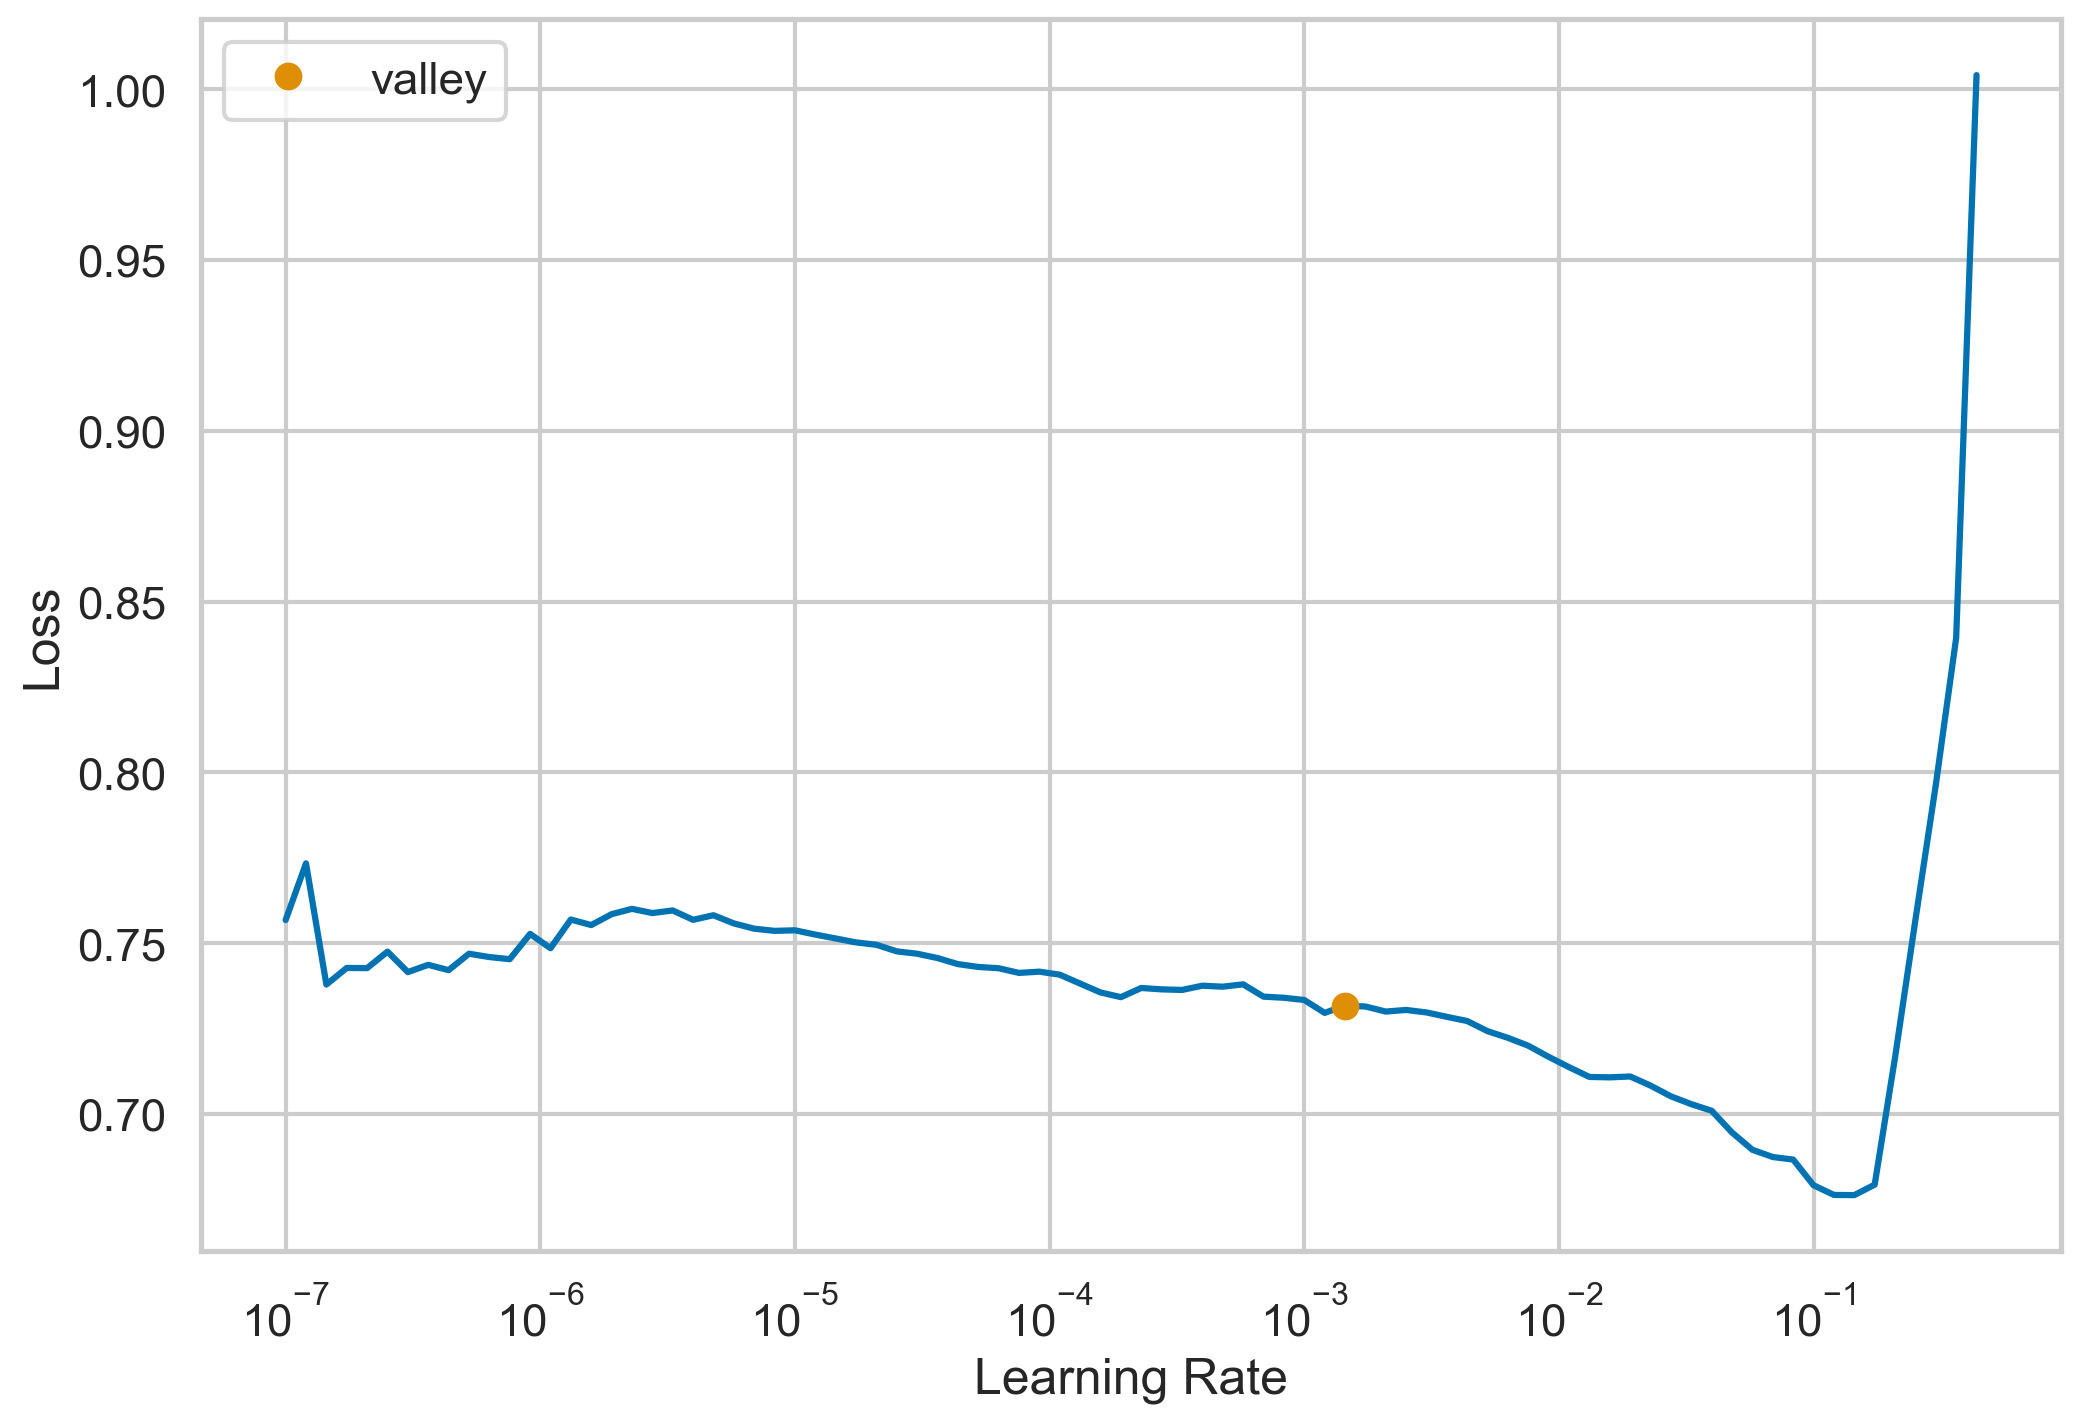

In [13]:
learn.lr_find()

### 9. Train the Tabular learner

In [14]:
learn.fit(n_epoch=25, lr=1e-3, wd=0.2)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,0.447733,0.435939,0.824833,0.398279,0.643489,00:09
1,0.444906,0.433846,0.824333,0.381064,0.649333,00:09
2,0.440631,inf,0.816500,0.325509,0.635115,00:09
3,0.436782,0.461438,0.821833,0.339593,0.658574,00:09
4,0.440361,0.427290,0.822833,0.335681,0.667185,00:08
5,0.441308,0.455435,0.824500,0.372457,0.654746,00:08
6,0.449740,inf,0.821667,0.389671,0.631980,00:08
7,0.425479,inf,0.819167,0.332551,0.646880,00:08
8,0.436430,inf,0.818167,0.398279,0.612515,00:08
9,0.439845,inf,0.816333,0.333333,0.630178,00:08


### 10. Plot the losses

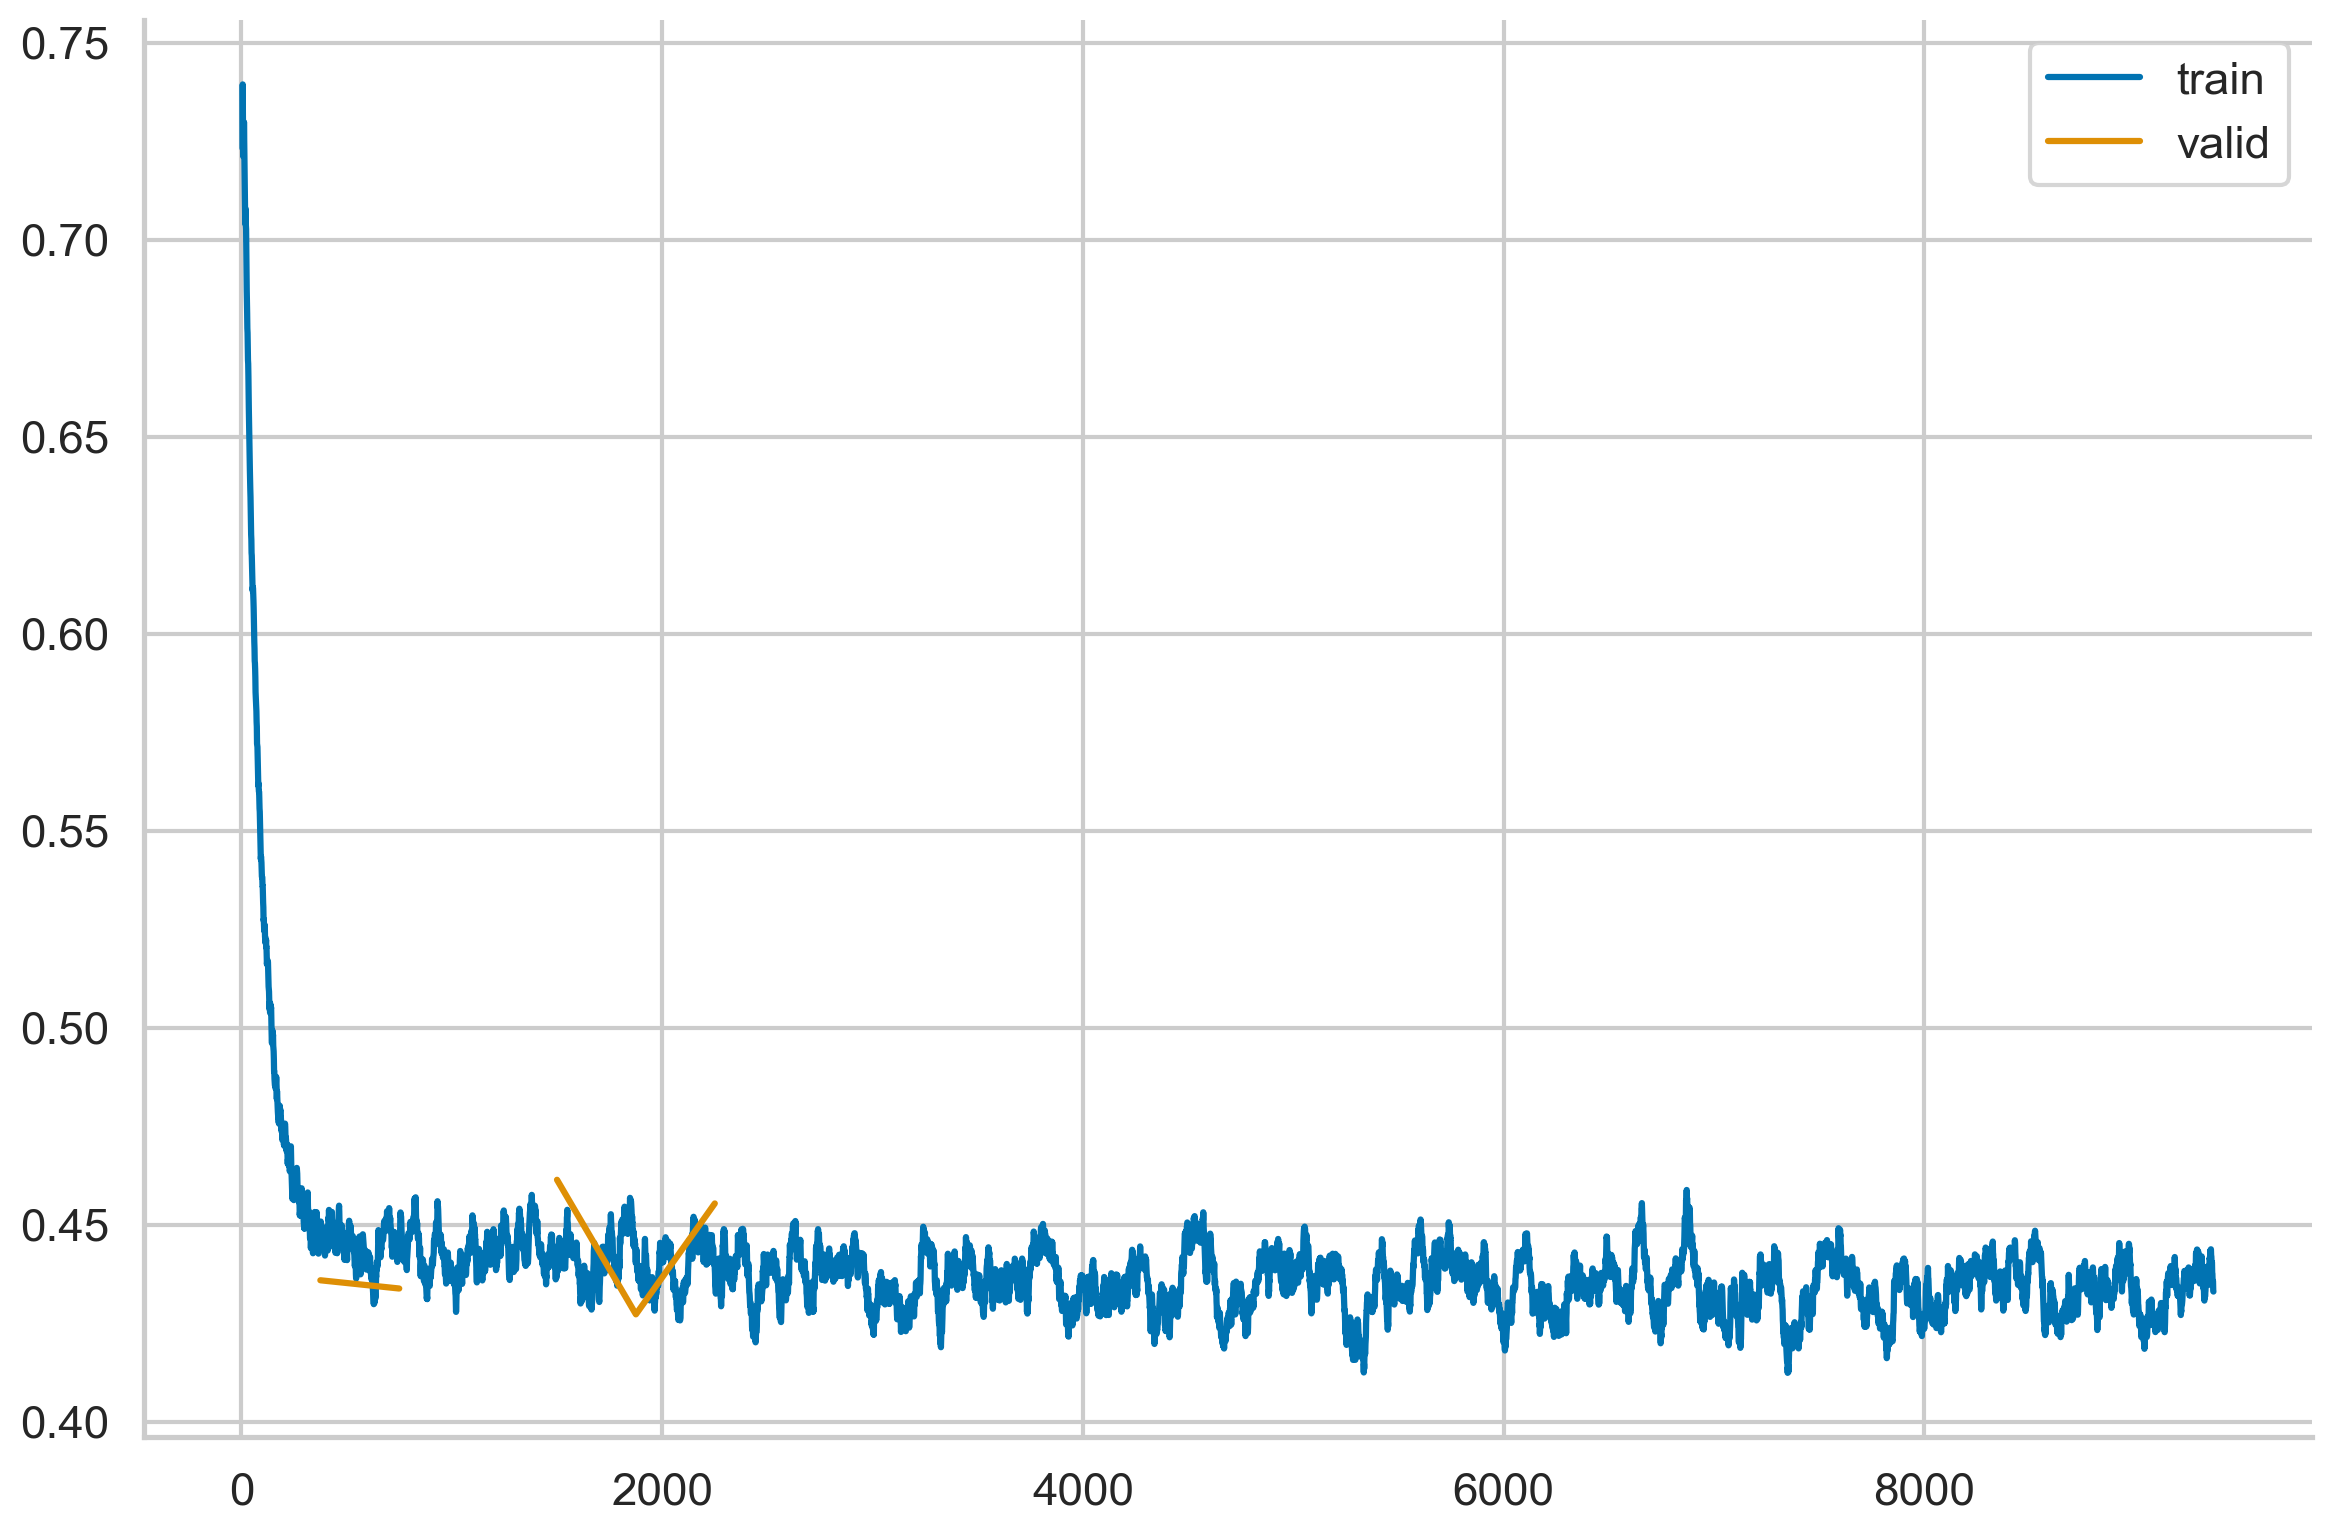

In [15]:
import seaborn as sns

learn.recorder.plot_loss()

plt.tight_layout()
sns.despine()

### 11. Define the validation `DataLoders`

In [16]:
valid_data_loader = learn.dls.test_dl(df.loc[list(splits[1])])
valid_data_loader.show_batch()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,Female,Graduate School,Single,Payment delayed 1 month,Unknown,Unknown,Unknown,Paid duly,Paid duly,False,80000.002671,28.0,0.000274,-0.001422,-0.000269,-0.000013,2284.000497,-786.000871,0.000039,-0.000043,-0.000163,2283.999916,0.000058,-0.000013,1
1,Female,Graduate School,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,360000.000553,44.0,347695.995104,329863.996200,322158.997157,289376.998417,146945.999005,130085.003447,19999.999860,20008.999765,30000.000210,9999.999766,9999.999951,10000.000060,0
2,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,80000.002671,31.0,0.000274,-0.001422,-0.000269,-0.000013,0.001374,0.001333,0.000039,-0.000043,-0.000163,-0.000076,0.000058,-0.000013,0
3,Female,University,Married,Paid duly,Paid duly,Paid duly,Paid duly,Paid duly,Paid duly,False,49999.996248,43.0,560.001359,1120.999531,194.999217,196.998524,196.998239,197.000509,1121.000175,194.999828,197.000070,197.000190,196.999852,196.999786,0
4,Male,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,179999.999837,26.0,145574.003103,108616.999401,102710.999113,95651.998160,97661.001694,99655.998778,3906.999985,3600.000028,3414.999937,3541.999967,3615.999970,1999.999949,0
5,Male,University,Single,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,Paid duly,Unknown,Paid duly,False,20000.005341,37.0,3254.001134,2521.998928,-0.000269,779.998506,390.000193,390.000078,1999.999921,-0.000043,780.000096,-0.000076,389.999981,1679.999945,1
6,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,279999.998942,44.0,286706.004848,272243.004586,203743.992187,203520.005928,207877.993990,211811.996533,10480.000231,8041.000065,7200.000052,7499.999924,7092.999917,5701.999989,0
7,Male,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,80000.002671,26.0,76157.999269,81858.000996,80337.000365,61002.000665,58147.999258,52514.999924,8000.000067,4999.999988,4000.000000,4999.999993,3000.000004,5000.000007,0
8,Male,Graduate School,Married,Unknown,Unknown,Unknown,Paid duly,Paid duly,Paid duly,False,209999.999471,52.0,44933.000212,38541.999976,39331.999888,11140.000617,8462.999592,10406.000874,1792.999970,8242.000014,12000.000196,8533.999995,11000.000119,7500.000042,0
9,Female,Graduate School,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,49999.996248,22.0,49459.000028,49281.000000,50071.000110,10104.000406,9208.000207,10075.000742,2299.999941,2000.000073,1000.000042,500.000082,999.999780,500.000043,0


### 12. Evaluate the performance on the validation set

In [17]:
learn.validate(dl=valid_data_loader)

(#4) [inf,0.8230000138282776,0.40688575899843504,0.6310679611650486]

### 13. Get predictions for the validation set

In [18]:
preds, y_true = learn.get_preds(dl=valid_data_loader)

In [19]:
preds

tensor([[0.7782, 0.2218],
        [0.9367, 0.0633],
        [0.8430, 0.1570],
        ...,
        [0.9010, 0.0990],
        [0.8963, 0.1037],
        [0.8852, 0.1148]])

In [20]:
preds.argmax(dim=-1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [21]:
y_true

tensor([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)

### 14. Inspect the performance evaluation metrics

In [22]:
# auto reload
%load_ext autoreload
%autoreload 2
from evaluation_report import performance_evaluation_report_fastai

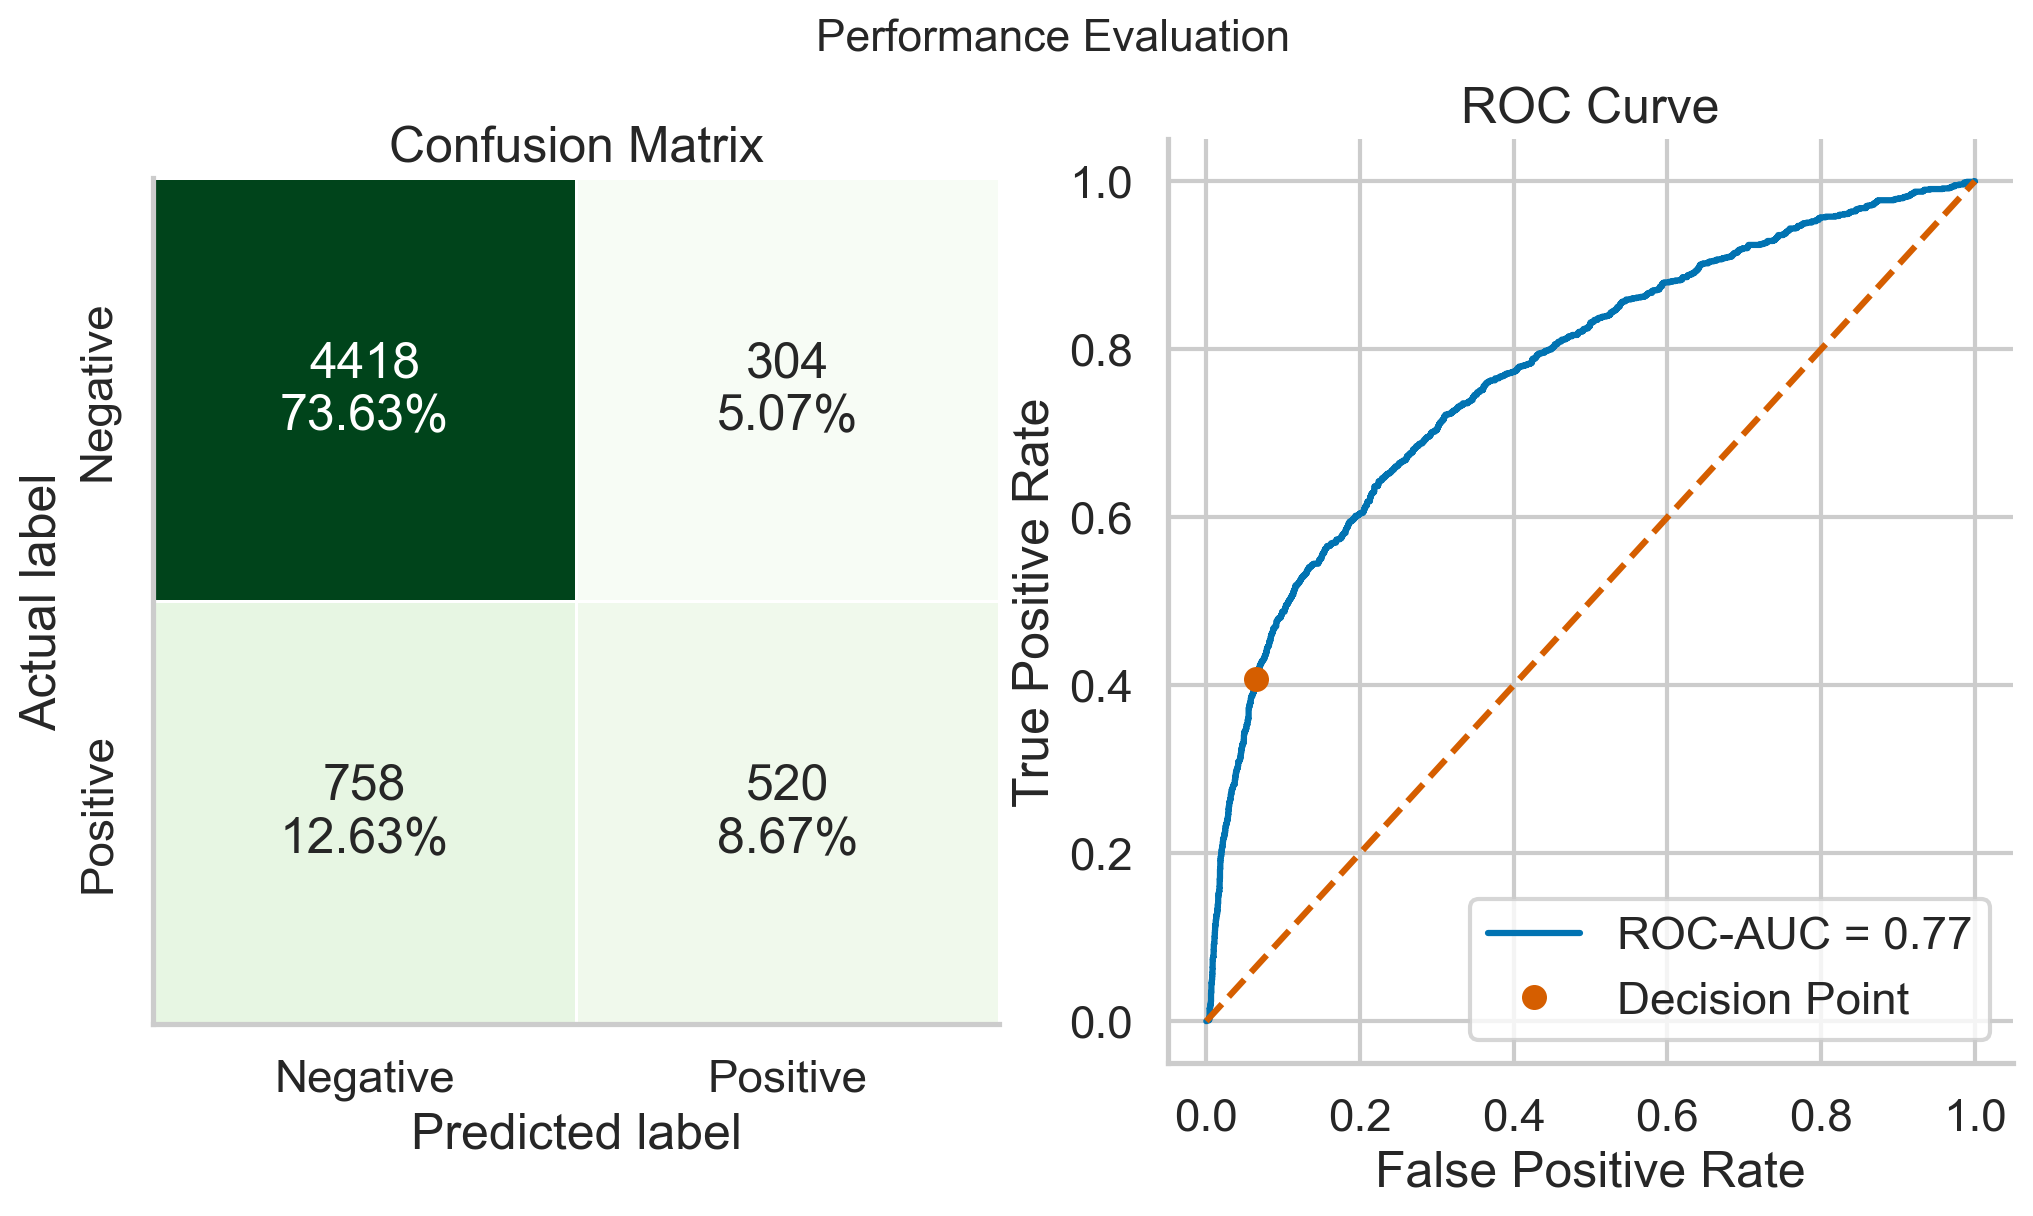

In [23]:
perf = performance_evaluation_report_fastai(
    learn, valid_data_loader, show_plot=True
)

sns.despine()

In [24]:
perf

{'accuracy': 0.823,
 'precision': 0.6310679611650486,
 'recall': 0.40688575899843504,
 'specificity': 0.9356204997882254,
 'f1_score': 0.4947668886774501,
 'cohens_kappa': 0.39348112138601565,
 'matthews_corr_coeff': 0.40741422698992175,
 'roc_auc': 0.7723141403837397,
 'pr_auc': 0.5101468841869515,
 'average_precision': 0.5103385452353577}

## There's more

In [25]:
from sklearn.model_selection import StratifiedKFold

X = df.copy()
y = X.pop(TARGET)

stat_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_ind, test_ind = next(stat_split.split(X, y))
ind_splits = IndexSplitter(valid_idx=list(test_ind))(range_of(df))

tabular_df = TabularPandas(
    df,
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=ind_splits
)

In [26]:
# we can look into the example results

learn.show_results()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month,default_payment_next_month_pred
0,1.0,4.0,1.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,-0.751244,0.168345,-0.022287,0.018456,0.007694,0.082639,0.154799,0.209007,-0.220534,-0.147362,-0.184906,-0.178392,-0.151487,-0.179519,1.0,0.0
1,1.0,1.0,1.0,10.0,1.0,1.0,1.0,9.0,9.0,1.0,1.784353,0.603651,0.712963,-0.691132,-0.658685,-0.374641,-0.327941,-0.280054,-0.339378,-0.200029,0.790450,-0.222051,-0.180734,-0.199696,0.0,0.0
2,1.0,1.0,3.0,1.0,1.0,1.0,1.0,9.0,9.0,1.0,-1.058589,-1.028745,-0.694475,-0.689491,-0.675218,-0.600118,-0.236092,-0.395359,-0.332398,-0.249388,-0.032939,1.266413,-0.118024,-0.167811,0.0,0.0
3,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.477008,0.168345,-0.690888,-0.685774,-0.671405,-0.666817,-0.656572,-0.645350,-0.316588,-0.238004,-0.276508,-0.279529,-0.292703,-0.251699,0.0,0.0
4,2.0,1.0,1.0,10.0,10.0,10.0,3.0,9.0,9.0,1.0,-0.213390,0.930130,0.529706,0.606637,0.712046,0.854608,0.995477,1.098860,-0.131044,-0.018488,-0.071116,0.010060,0.015829,-0.011857,0.0,0.0
5,1.0,4.0,1.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,-0.597572,-1.137571,0.095863,0.120086,0.051984,0.036241,0.039948,-0.002016,-0.158308,-0.168068,-0.183029,-0.177387,-0.184282,-0.181793,0.0,0.0
6,2.0,1.0,1.0,1.0,1.0,1.0,10.0,9.0,1.0,1.0,2.552716,0.821304,-0.494823,0.053969,0.394663,0.278576,-0.046356,-0.608421,2.847269,2.948166,-0.222286,-0.247052,-0.145330,2.134621,0.0,0.0
7,1.0,1.0,3.0,1.0,1.0,10.0,10.0,9.0,9.0,1.0,-0.674408,-1.464050,-0.554839,-0.529935,-0.502720,-0.673407,-0.617661,-0.650407,0.346300,-0.211800,-0.296819,-0.123678,-0.312781,-0.296031,0.0,0.0
8,2.0,4.0,3.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,-0.520735,-1.246397,0.488156,0.551810,0.649481,0.807696,-0.176703,-0.593437,-0.131044,-0.039967,-0.014220,-0.052757,-0.118024,-0.011857,1.0,0.0


In [27]:
# or create predictions for a single row

row, clas, probs = learn.predict(df.iloc[0])

In [28]:
row

   sex  education  marriage  payment_status_sep  payment_status_aug  \
0  1.0        4.0       1.0                 3.0                 3.0   

   payment_status_jul  payment_status_jun  payment_status_may  \
0                 1.0                 1.0                 9.0   

   payment_status_apr  age_na  ...  bill_statement_jun  bill_statement_may  \
0                 9.0     1.0  ...           -0.672893           -0.663007   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0           -0.651923             -0.339855              -0.22516   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0             -0.298697             -0.304028             -0.318804   

   previous_payment_apr  default_payment_next_month  
0             -0.296031                         1.0  

[1 rows x 25 columns]

In [29]:
clas

tensor(1)

In [30]:
probs

tensor([0.3645, 0.6355])

# Exploring Google's TabNet

## How to do it

### 1. Import the libraries

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
import torch
import pandas as pd
import numpy as np

### 2. Load the dataset from CSV file

In [32]:
df = pd.read_csv('./datasets/credit_card_default.csv', na_values="")

### 3. Separate the target from the features and create lists with numerical/categorical features

In [33]:
X = df.copy()
y = X.pop("default_payment_next_month")
cat_features = list(X.select_dtypes("object").columns)
num_features = list(X.select_dtypes("number").columns)

In [34]:
# as a reminder, where the possible missing values are
X.isna().any()

limit_bal               False
sex                      True
education                True
marriage                 True
age                      True
payment_status_sep      False
payment_status_aug      False
payment_status_jul      False
payment_status_jun      False
payment_status_may      False
payment_status_apr      False
bill_statement_sep      False
bill_statement_aug      False
bill_statement_jul      False
bill_statement_jun      False
bill_statement_may      False
bill_statement_apr      False
previous_payment_sep    False
previous_payment_aug    False
previous_payment_jul    False
previous_payment_jun    False
previous_payment_may    False
previous_payment_apr    False
dtype: bool

### 4. Impute missing values in the categorical features, encode them using `LabelEncoder`, and store the number of unique categories per feature.

In [35]:
cat_dims = {}
for col in cat_features:
    label_encoder = LabelEncoder()
    X[col] = X[col].fillna("Missing")
    X[col] = label_encoder.fit_transform(X[col].values)
    cat_dims[col] = len(label_encoder.classes_)
cat_dims

{'sex': 3,
 'education': 5,
 'marriage': 4,
 'payment_status_sep': 10,
 'payment_status_aug': 10,
 'payment_status_jul': 10,
 'payment_status_jun': 10,
 'payment_status_may': 9,
 'payment_status_apr': 9}

### 5. Create a train/valid/test split using the 70-15-15 split

In [36]:
# create the initial split - training and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,
    stratify=y,
    random_state=42
)

# create the valid and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

In [37]:
print("Percentage of data in each set ----")
print(f"Train: {100 * len(X_train) / len(X):.2f}%")
print(f"Valid: {100 * len(X_valid) / len(X):.2f}%")
print(f"Test: {100 * len(X_test) / len(X):.2f}%")
print("")
print("Class distribution in each set ----")
print(f"Train: {y_train.value_counts(normalize=True).values}")
print(f"Valid: {y_valid.value_counts(normalize=True).values}")
print(f"Test: {y_test.value_counts(normalize=True).values}")

Percentage of data in each set ----
Train: 70.00%
Valid: 15.00%
Test: 15.00%

Class distribution in each set ----
Train: [0.77880952 0.22119048]
Valid: [0.77888889 0.22111111]
Test: [0.77866667 0.22133333]


### 6. Impute the missing values in the numerical features across all the sets

In [38]:
for col in num_features:
    imp_mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(imp_mean)
    X_valid[col] = X_valid[col].fillna(imp_mean)
    X_test[col] = X_test[col].fillna(imp_mean)

### 7. Prepare lists with the indices of categorical features and the number of unique categories

In [39]:
features = X.columns.to_list()
cat_ind = [features.index(feat) for feat in cat_features]
cat_dims = list(cat_dims.values())
cat_ind

[1, 2, 3, 5, 6, 7, 8, 9, 10]

### 8. Define a custom recall metric

In [40]:
class Recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return recall_score(y_true, y_pred)

### 9. Define TabNet’s parameters and instantiate the classifier

In [41]:
tabnet_params = {
    "cat_idxs": cat_ind,
    "cat_dims": cat_dims,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2),
    "scheduler_params": {
        "step_size": 20,
        "gamma": 0.9
    },
    "scheduler_fn": torch.optim.lr_scheduler.StepLR,
    "mask_type": "sparsemax",
    "seed": 42
}

tabnet = TabNetClassifier(**tabnet_params)

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


### 10.Train the TabNet classifier

In [42]:
tabnet.fit(
    X_train = X_train.values,
    y_train = y_train.values,
    eval_set = [
        (X_train.values, y_train.values),
        (X_valid.values, y_valid.values)
    ],
    eval_name=["train", "valid"],
    eval_metric=["auc", Recall],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    weights=1
)

epoch 0  | loss: 0.69395 | train_auc: 0.63377 | train_recall: 0.53154 | valid_auc: 0.61624 | valid_recall: 0.49347 |  0:00:03s
epoch 1  | loss: 0.62933 | train_auc: 0.68349 | train_recall: 0.47126 | valid_auc: 0.66452 | valid_recall: 0.42613 |  0:00:06s
epoch 2  | loss: 0.60389 | train_auc: 0.7032  | train_recall: 0.52207 | valid_auc: 0.70171 | valid_recall: 0.48945 |  0:00:08s
epoch 3  | loss: 0.59829 | train_auc: 0.73087 | train_recall: 0.52939 | valid_auc: 0.73579 | valid_recall: 0.49648 |  0:00:10s
epoch 4  | loss: 0.58541 | train_auc: 0.73734 | train_recall: 0.60969 | valid_auc: 0.73777 | valid_recall: 0.59698 |  0:00:12s
epoch 5  | loss: 0.58523 | train_auc: 0.74898 | train_recall: 0.52379 | valid_auc: 0.74318 | valid_recall: 0.49146 |  0:00:14s
epoch 6  | loss: 0.58585 | train_auc: 0.75048 | train_recall: 0.55285 | valid_auc: 0.74907 | valid_recall: 0.53166 |  0:00:17s
epoch 7  | loss: 0.58394 | train_auc: 0.75935 | train_recall: 0.53369 | valid_auc: 0.75168 | valid_recall: 0.51

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### 11. Prepare the history DataFrame and plot the scores over epochs

In [43]:
history_df = pd.DataFrame(tabnet.history.history)
history_df.head(10)

,loss,lr,train_auc,train_recall,valid_auc,valid_recall
0,0.693948,0.02,0.633772,0.531539,0.616238,0.493467
1,0.629334,0.02,0.683494,0.471259,0.664523,0.426131
2,0.603894,0.02,0.703203,0.522067,0.701710,0.489447
3,0.598290,0.02,0.730868,0.529386,0.735792,0.496482
4,0.585413,0.02,0.737340,0.609688,0.737766,0.596985
5,0.585231,0.02,0.748980,0.523789,0.743178,0.491457
6,0.585850,0.02,0.750483,0.552853,0.749066,0.531658
7,0.583941,0.02,0.759347,0.533692,0.751679,0.512563
8,0.575723,0.02,0.763152,0.533907,0.753129,0.509548
9,0.573582,0.02,0.765134,0.550484,0.754963,0.526633


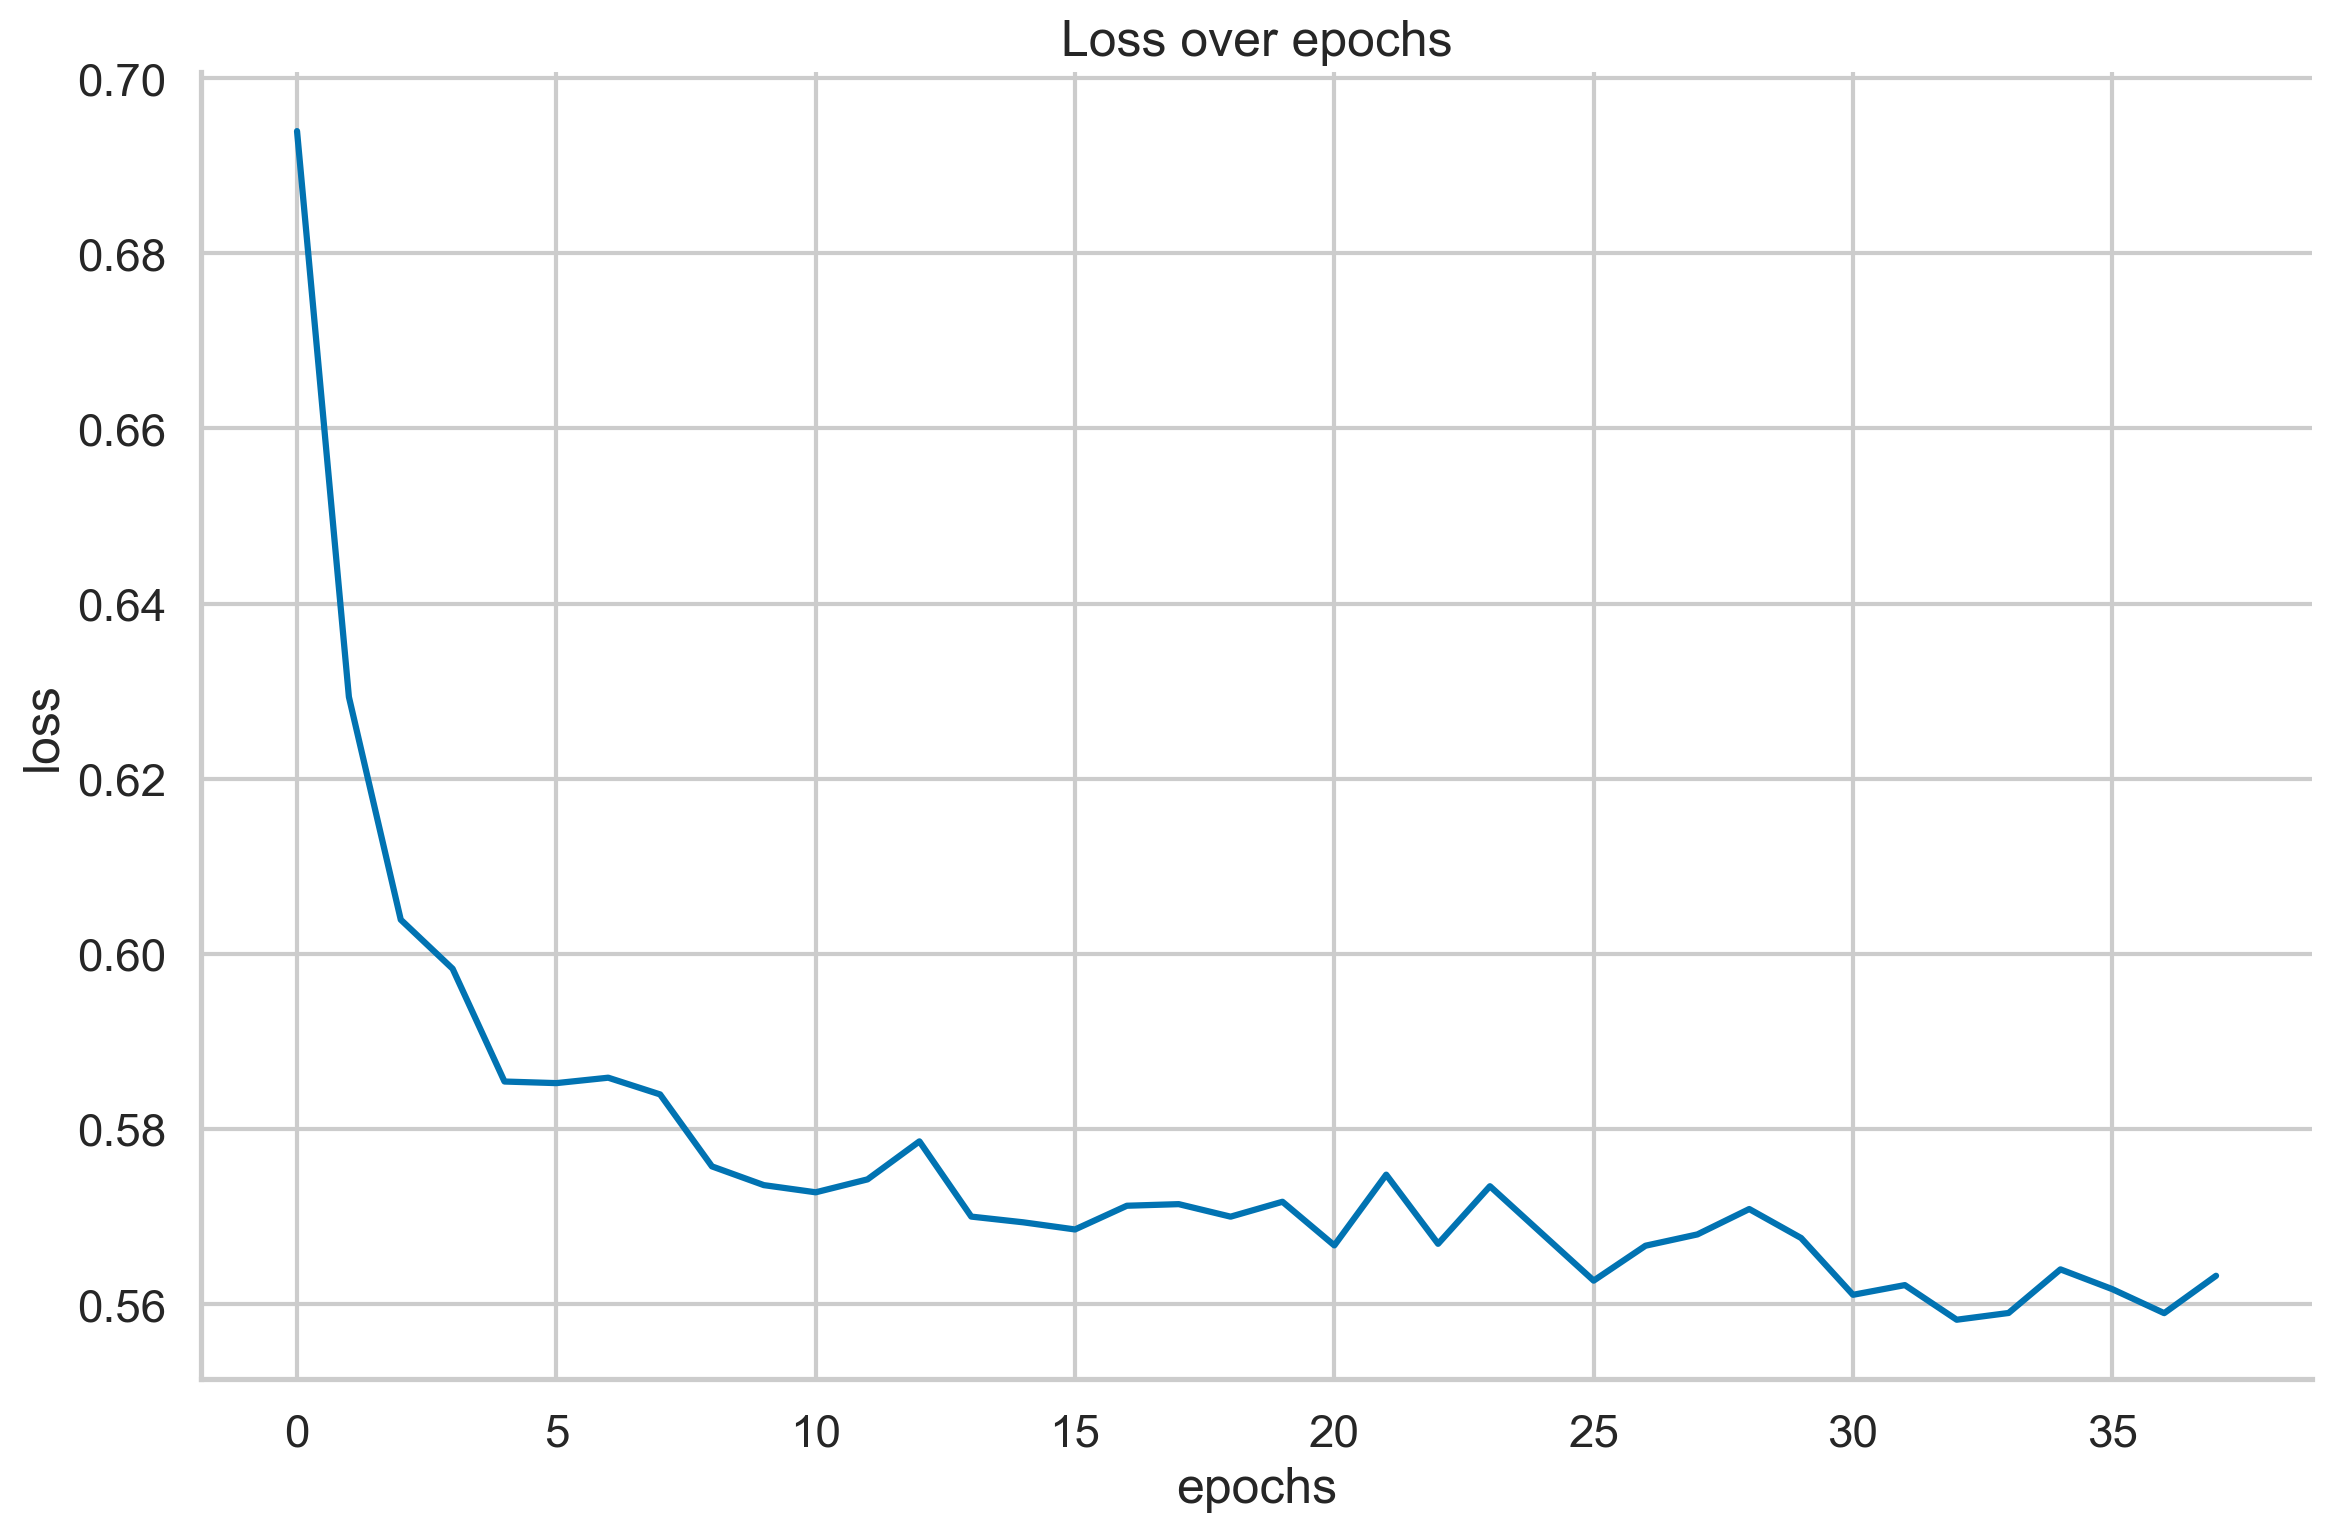

In [45]:
history_df["loss"].plot(
    title="Loss over epochs",
    xlabel="epochs",
    ylabel="loss"
)
plt.tight_layout()
sns.despine()

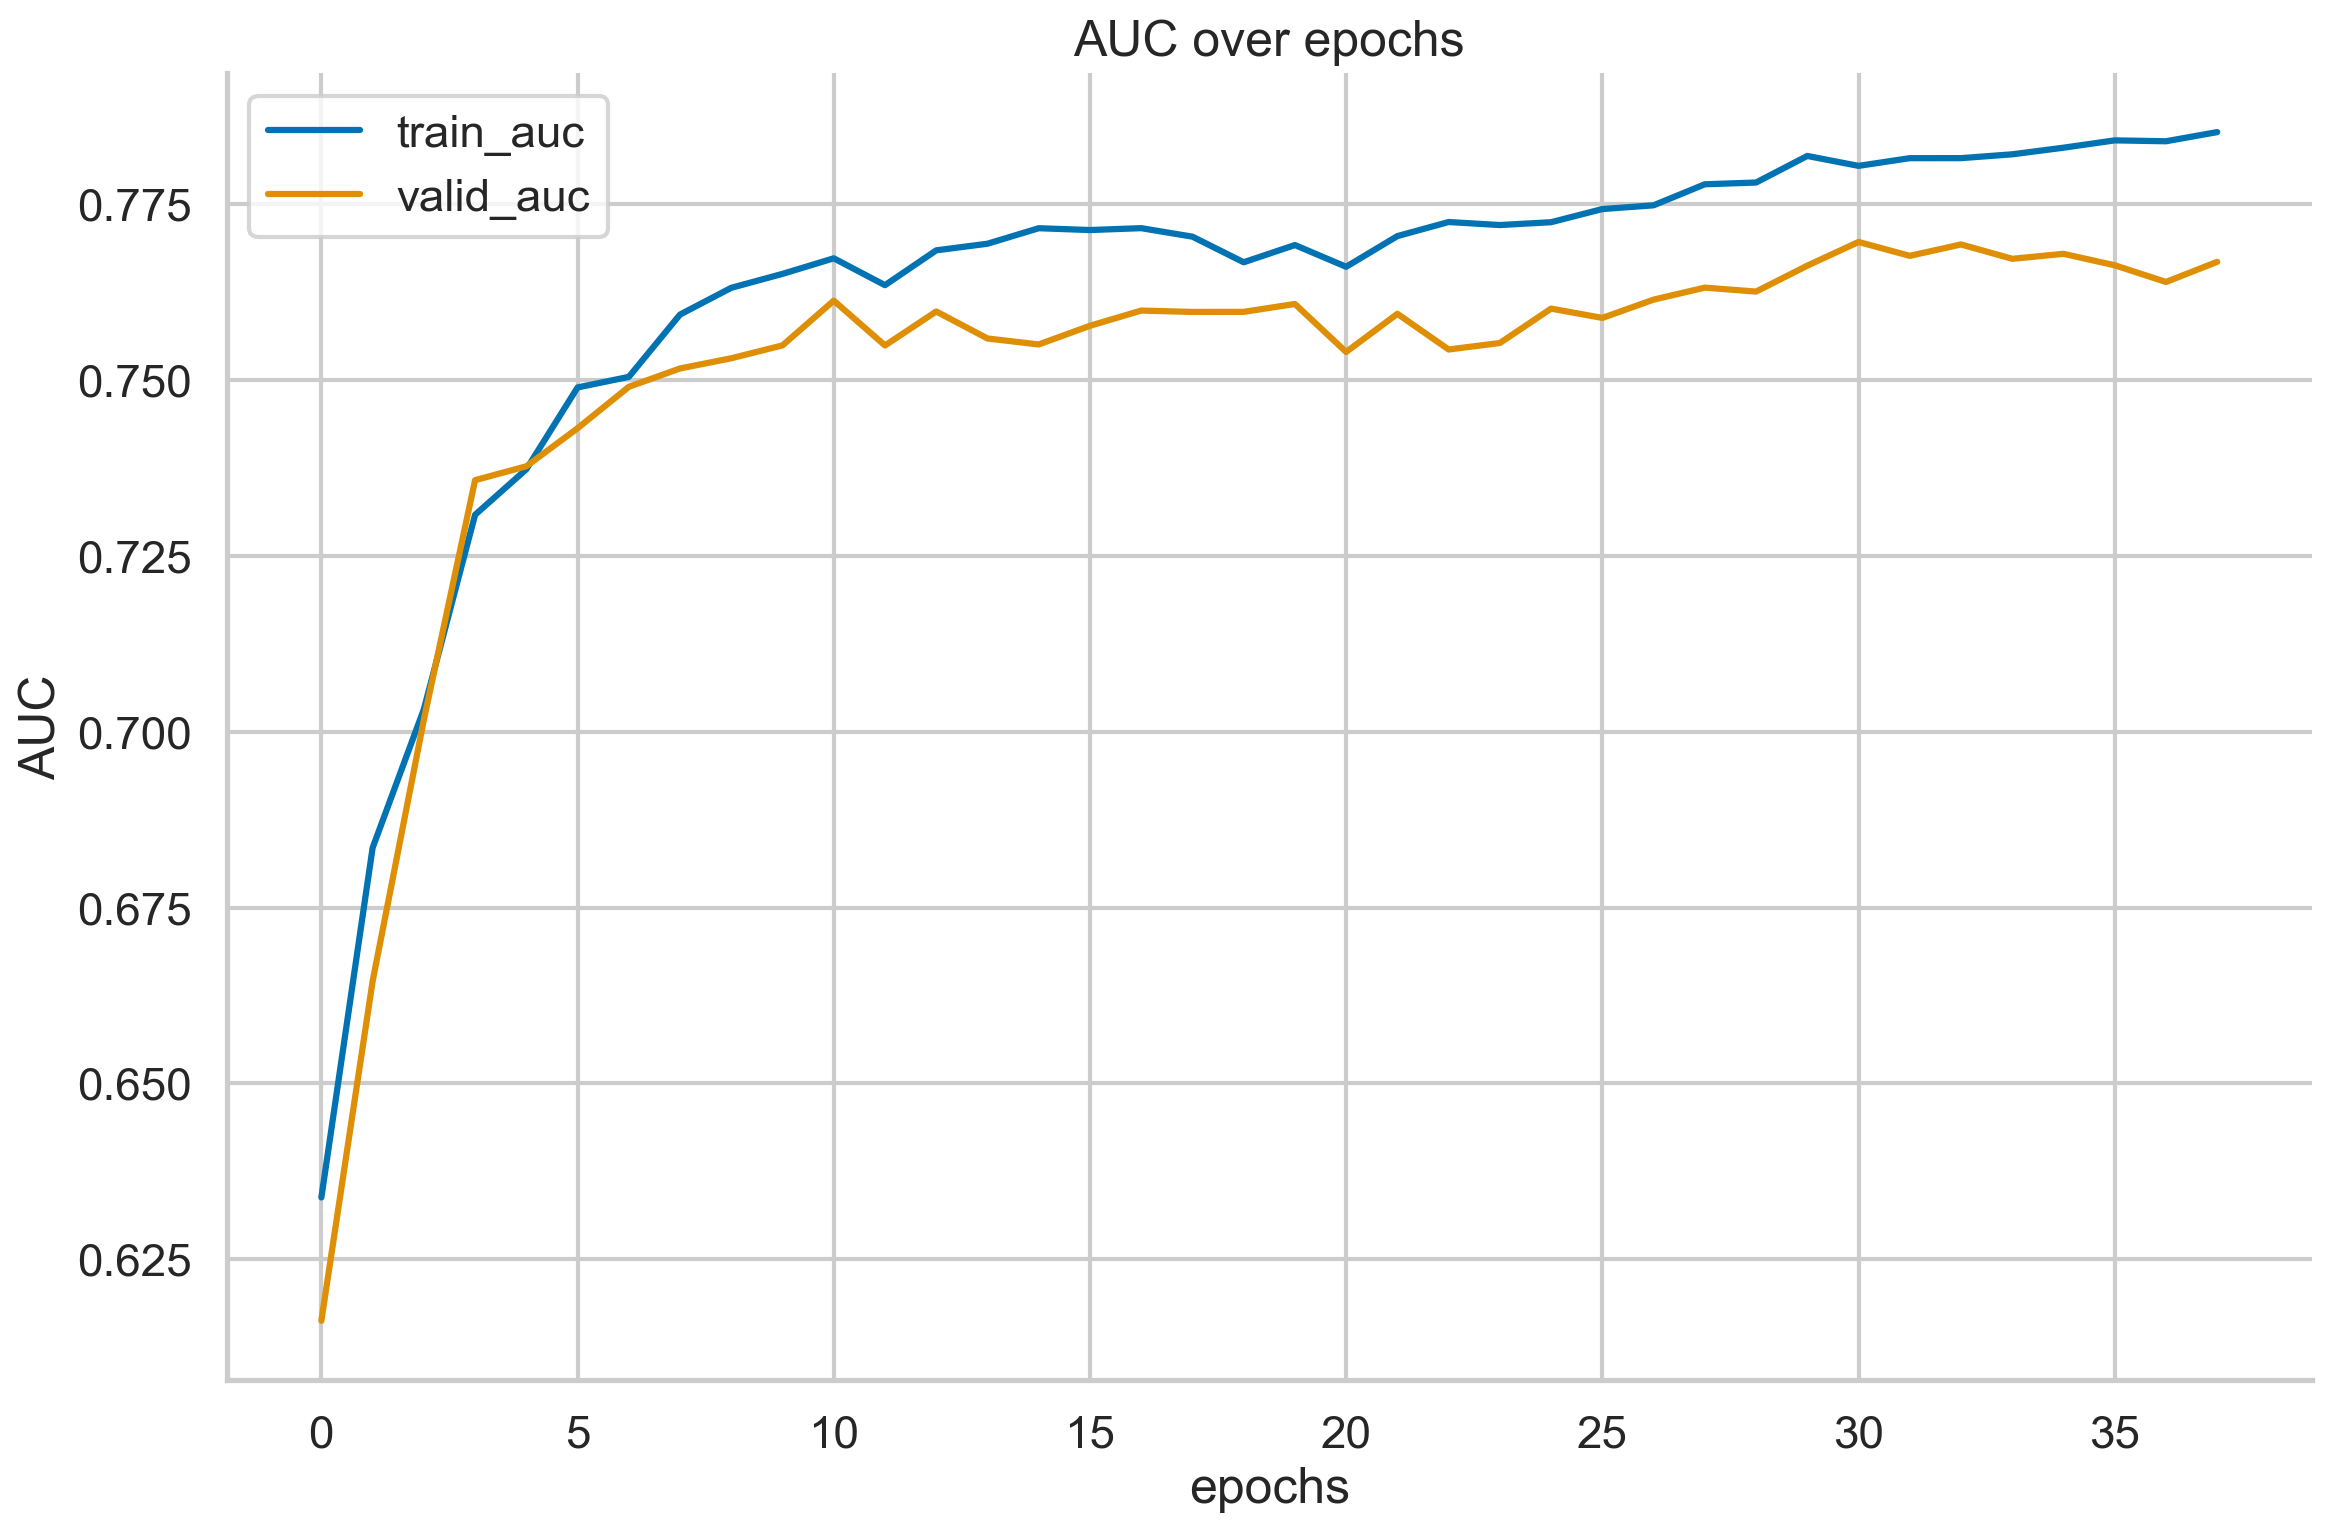

In [46]:
(
    history_df[["train_auc", "valid_auc"]]
    .plot(title="AUC over epochs",
          xlabel="epochs",
          ylabel="AUC")
)
plt.tight_layout()
sns.despine()

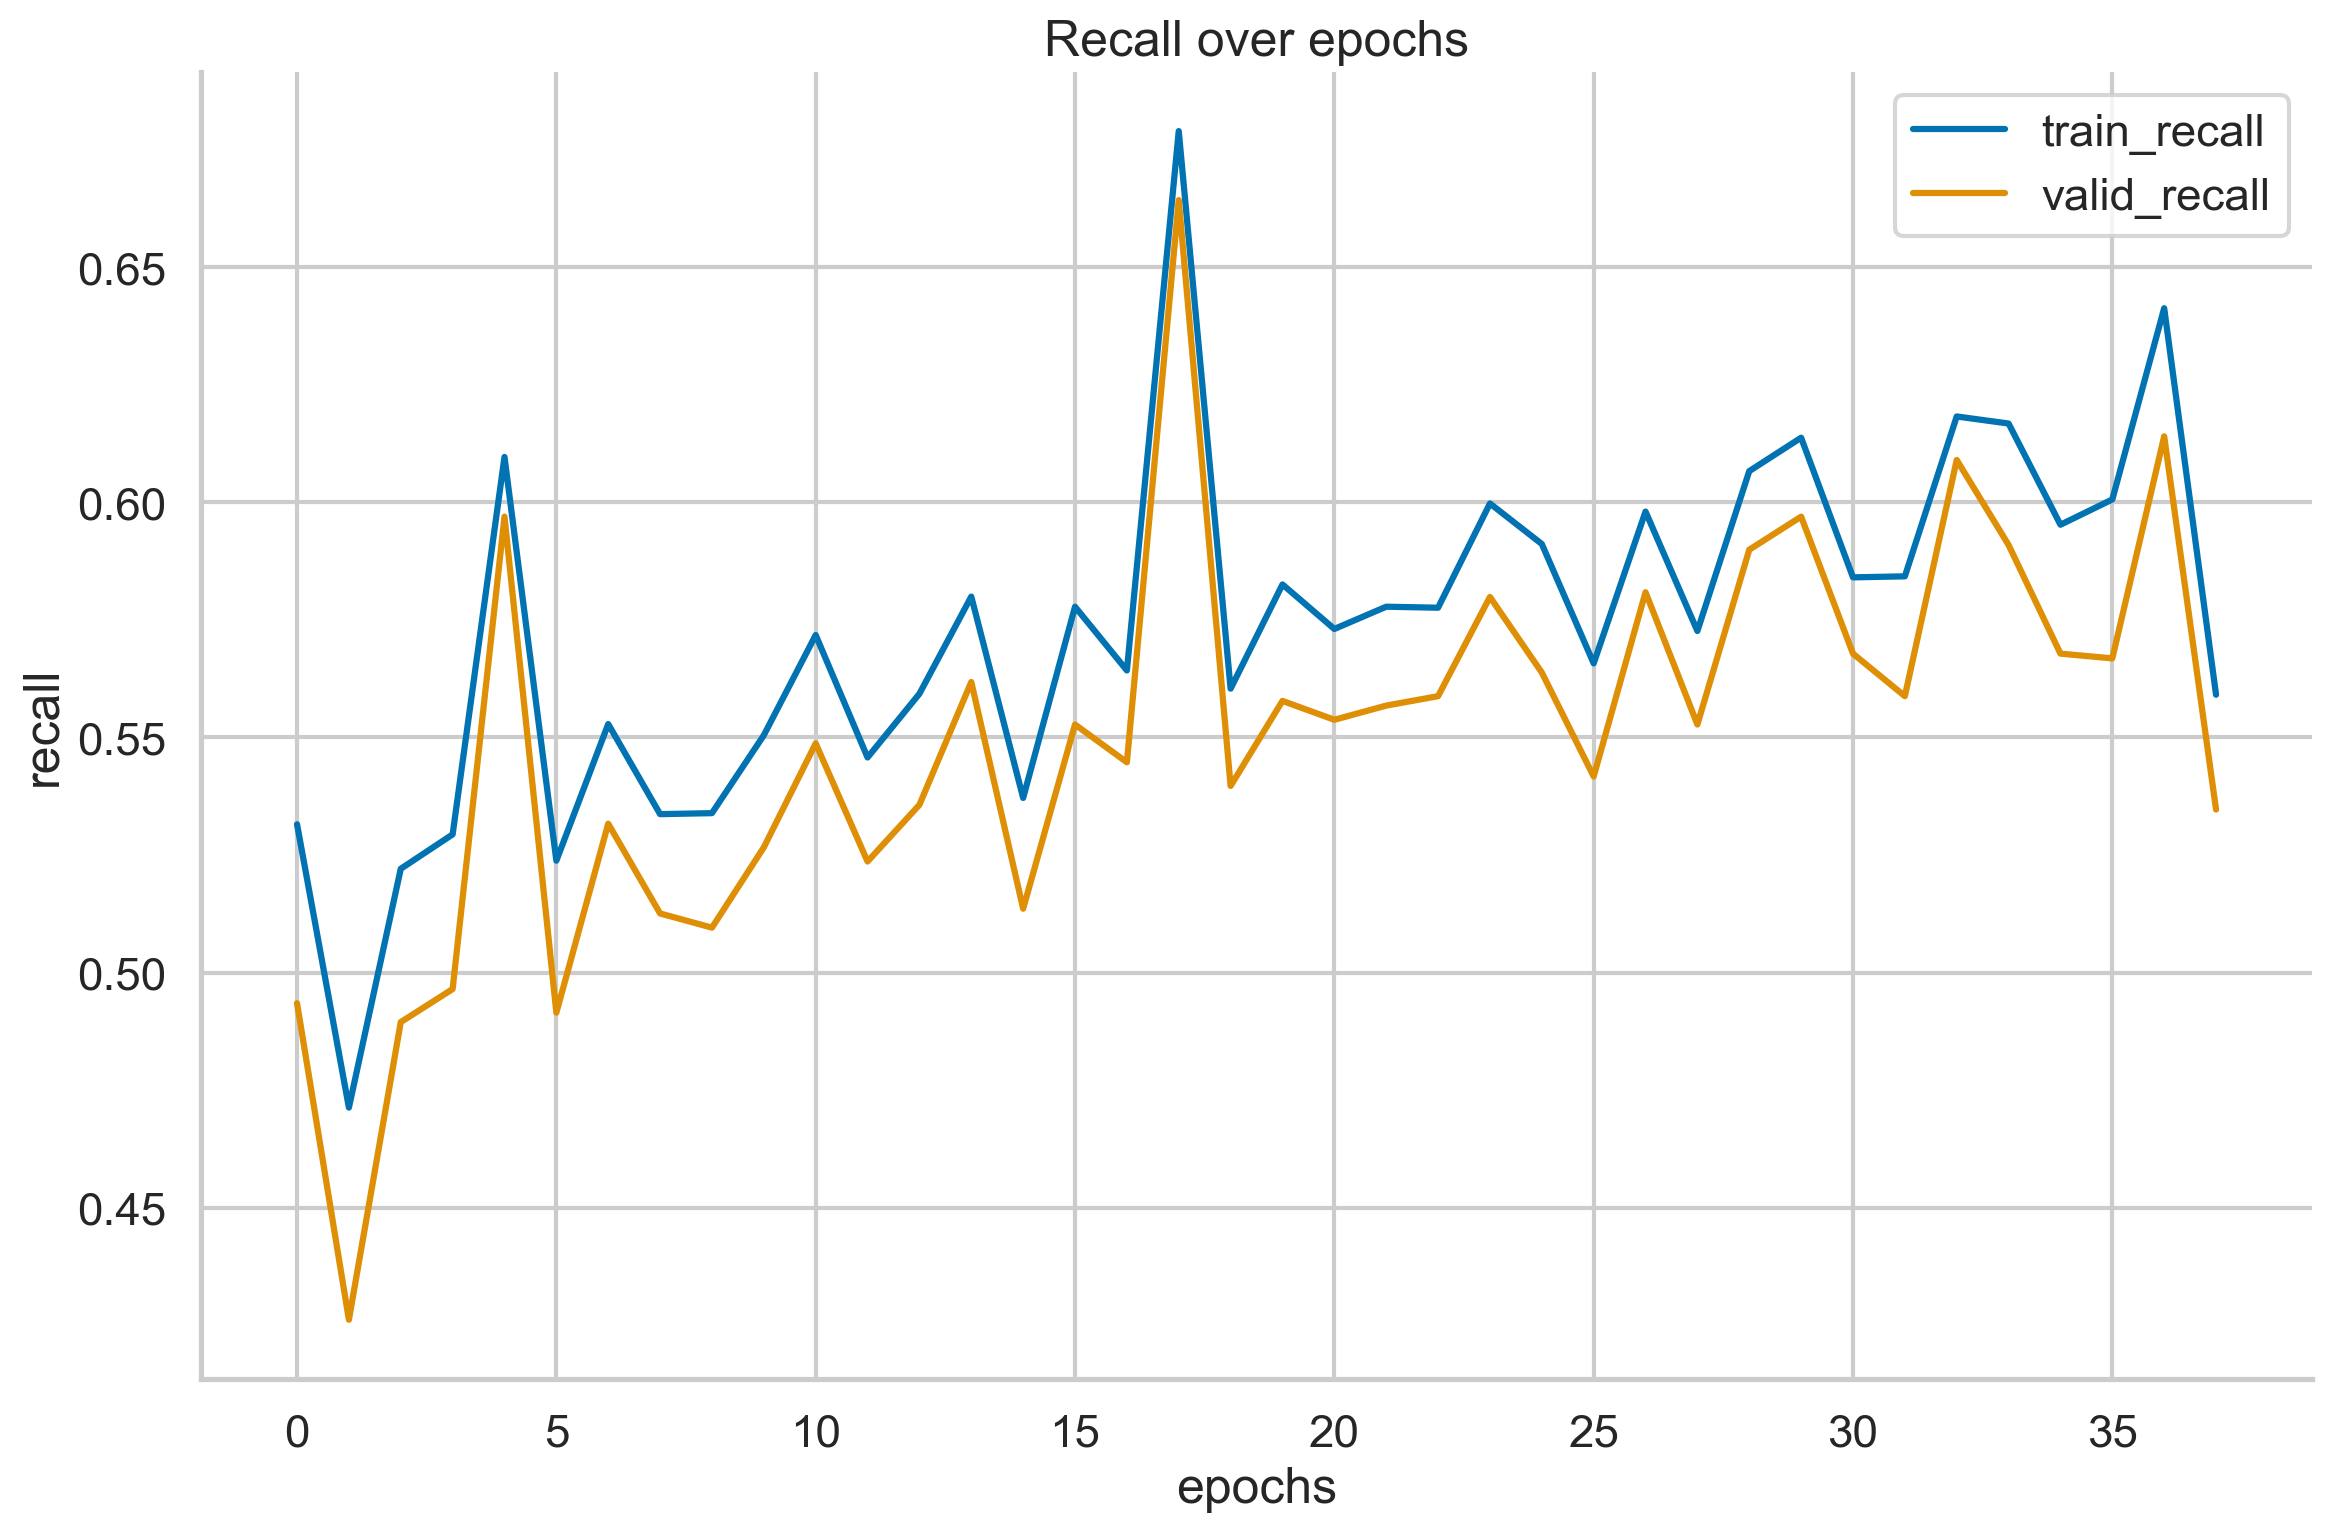

In [47]:
(
    history_df[["train_recall", "valid_recall"]]
    .plot(title="Recall over epochs",
          xlabel="epochs",
          ylabel="recall")
)
plt.tight_layout()
sns.despine()

### 12. Create predictions for the test set and evaluate their performance

In [48]:
y_pred = tabnet.predict(X_test.values)

print(f"Best validation score: {tabnet.best_cost:.4f}")
print(f"Test set score: {recall_score(y_test, y_pred):.4f}")

Best validation score: 0.6643
Test set score: 0.6767


### 13. Extract and plot the global feature importance

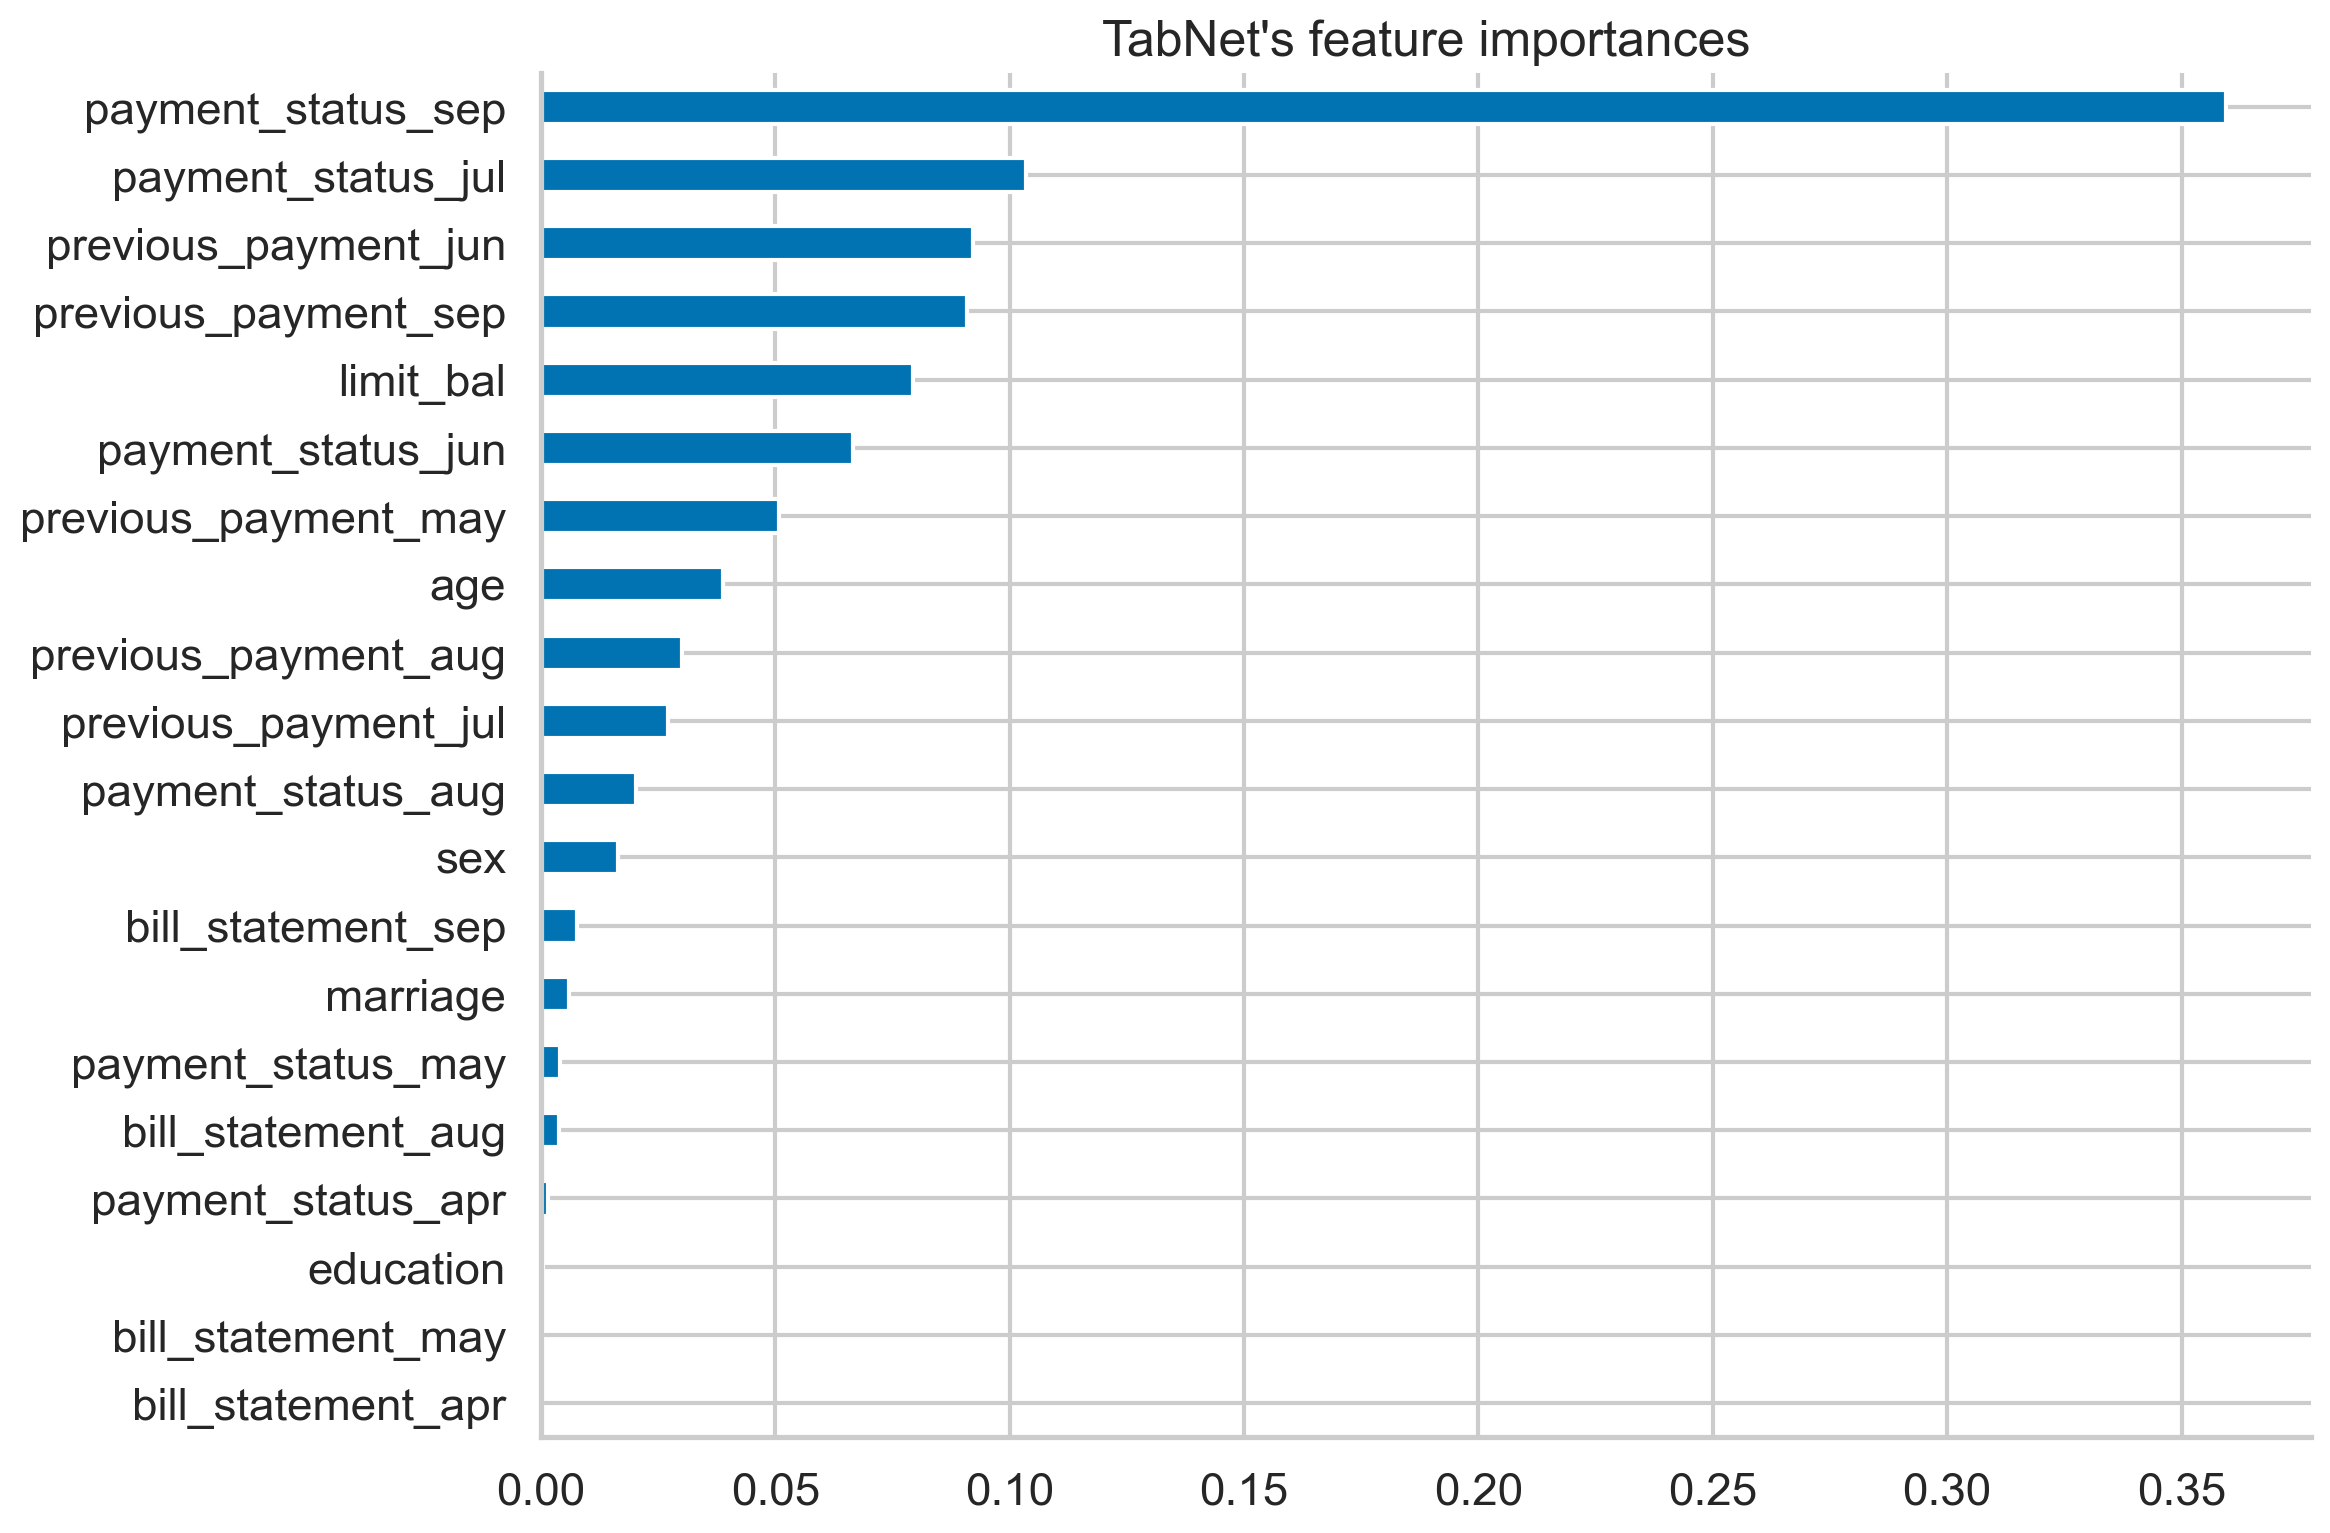

In [49]:
tabnet_feat_imp = pd.Series(tabnet.feature_importances_, index=X_train.columns)
(
    tabnet_feat_imp
    .nlargest(20)
    .sort_values()
    .plot(kind="barh",
          title="TabNet's feature importances")
)

plt.tight_layout()
sns.despine()

In [50]:
np.sum(tabnet.feature_importances_)

0.9999999999999999

## There's more

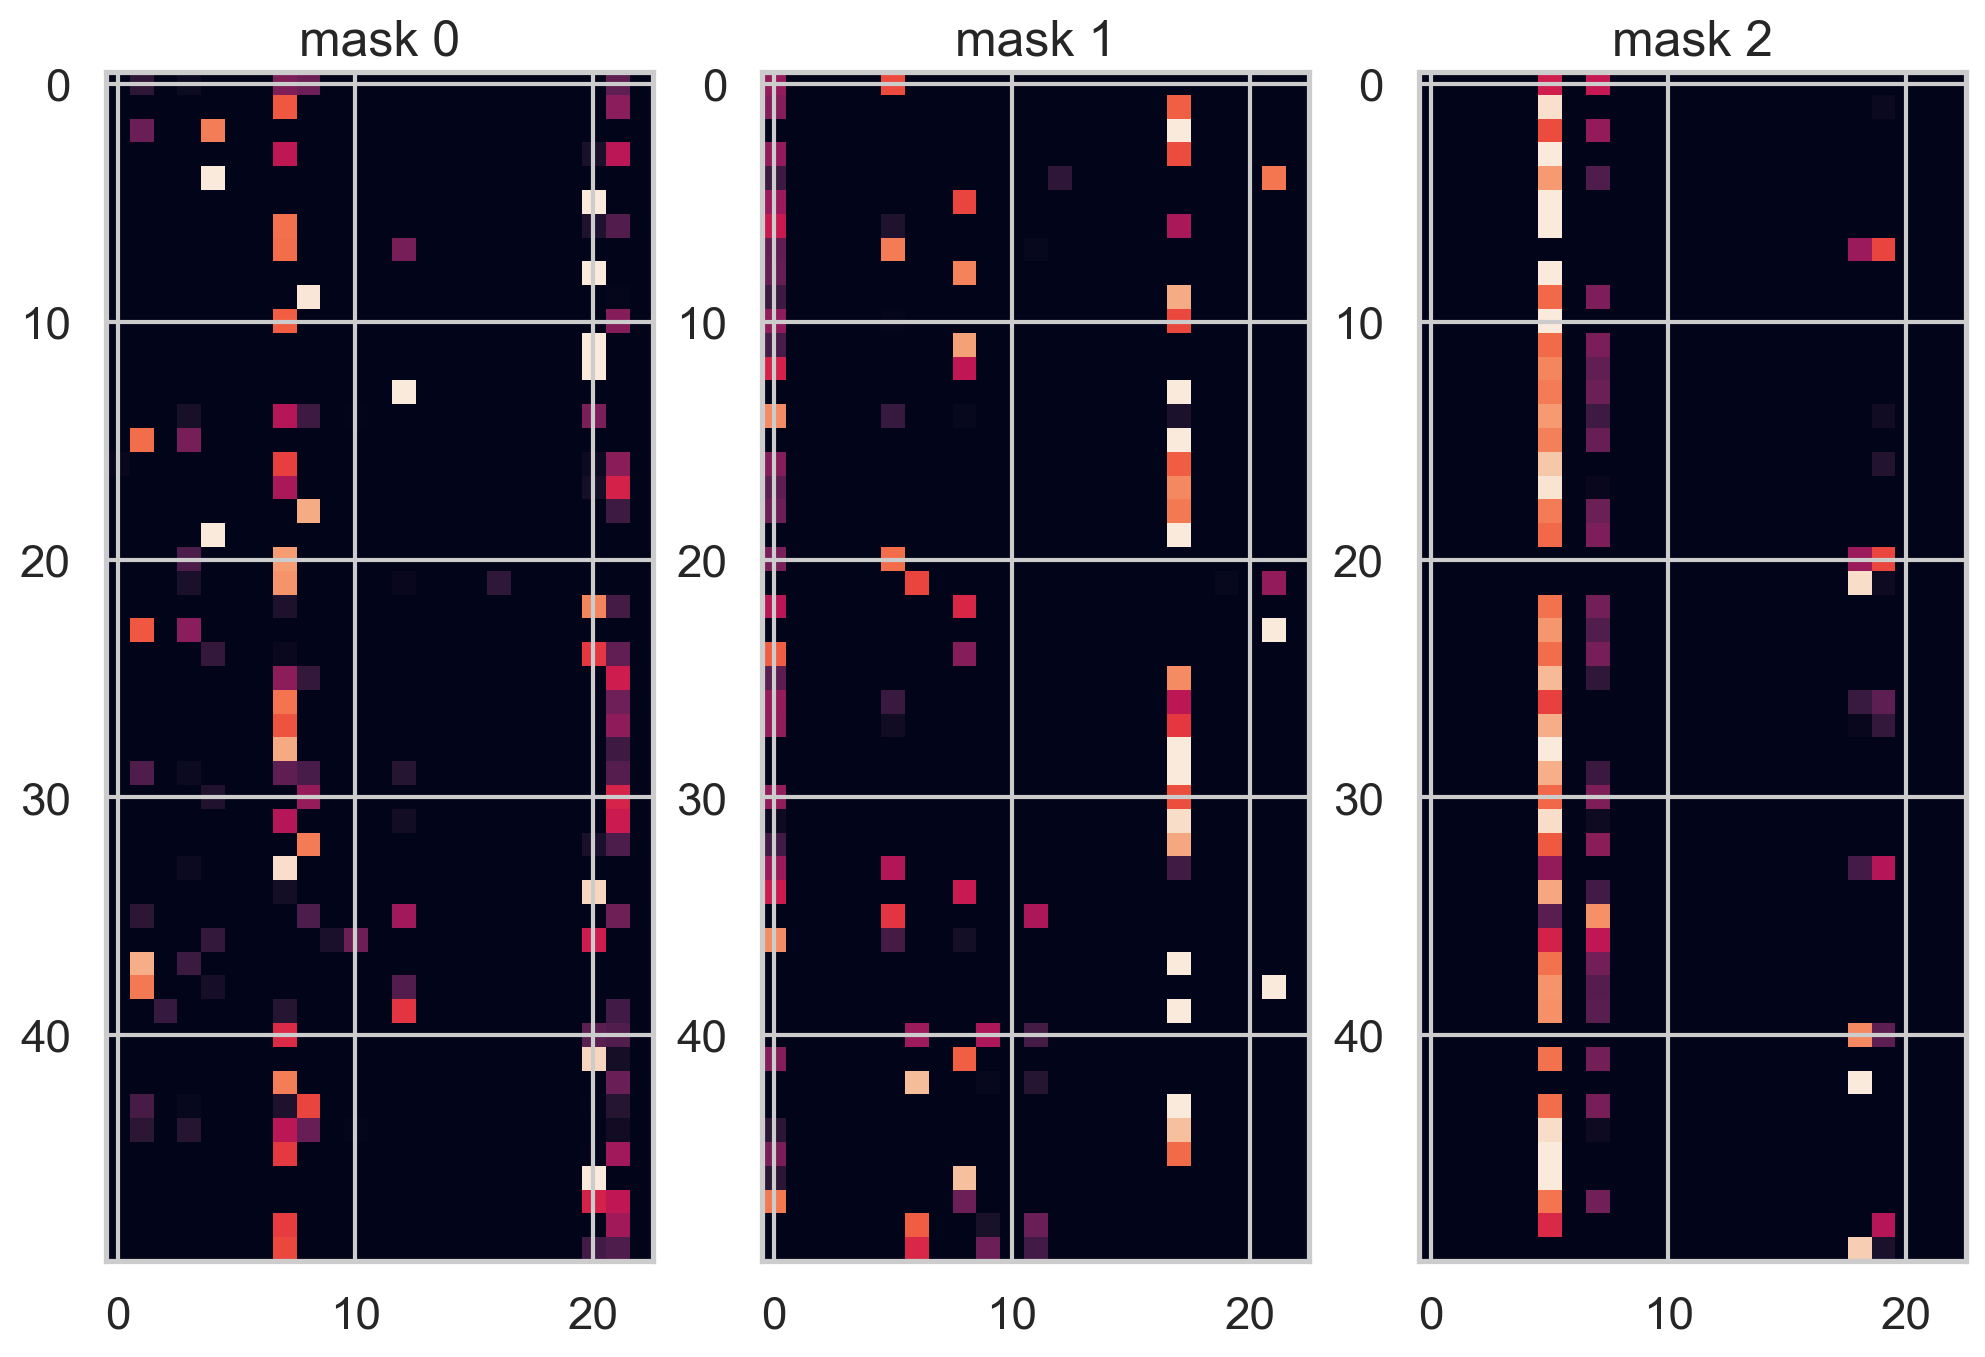

In [51]:
explain_matrix, masks = tabnet.explain(X_test.values)

fig, axs = plt.subplots(1, 3)

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [52]:
explain_matrix.shape

(4500, 23)

In [53]:
X_test.shape

(4500, 23)

In [54]:
# save tabnet model
MODEL_PATH = "./models/tabnet_model"
saved_filepath = tabnet.save_model(MODEL_PATH)

# define new model with basic parameters and load state dict weights
loaded_tabnet = TabNetClassifier()
loaded_tabnet.load_model(saved_filepath)

Successfully saved model at ./models/tabnet_model.zip


/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Time series forecasting with Amazon's DeepAR